<a href="https://colab.research.google.com/github/prant1719/BADS7105-CRM/blob/main/HW6-%20Customer_Segmentation/HW6_Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**SET UP Pycaret**

In [ ]:
!pip install pycaret

In [ ]:
import pandas as pd
from pycaret.clustering import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

**Load Data**

In [ ]:
df = pd.read_csv('Supermarket Data.csv')

In [ ]:
df['SHOP_DATE'] = df['SHOP_DATE'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

In [ ]:
# Add variables
df['WK_DAY'] = np.where(np.logical_and(df['SHOP_WEEKDAY'] >= 2,df['SHOP_WEEKDAY'] <= 6),1,0)


df['WK_END'] = np.where(np.logical_or(df['SHOP_WEEKDAY'] == 1,df['SHOP_WEEKDAY'] == 7),1,0)

df['HOUR_DAY'] = np.where(np.logical_and(df['SHOP_HOUR'] >= 6,df['SHOP_HOUR'] <= 18),1,0)


df['HOUR_NIGHT'] = np.where(np.logical_or(df['SHOP_HOUR'] < 6,df['SHOP_HOUR'] > 18),1,0)

In [ ]:
df.tail(5)

SHOP_WEEK  SHOP_DATE  SHOP_WEEKDAY  SHOP_HOUR  QUANTITY  SPEND  \
956569     200617 2006-06-22             5         12         3   3.96   
956570     200633 2006-10-13             6         20         3   3.96   
956571     200617 2006-06-22             5         18         3   3.96   
956572     200619 2006-07-06             5         19         3   3.96   
956573     200635 2006-10-23             2         21         3   3.96   

         PROD_CODE PROD_CODE_10 PROD_CODE_20 PROD_CODE_30 PROD_CODE_40  \
956569  PRD0904997      CL00074     DEP00021       G00007       D00002   
956570  PRD0904997      CL00074     DEP00021       G00007       D00002   
956571  PRD0904997      CL00074     DEP00021       G00007       D00002   
956572  PRD0904997      CL00074     DEP00021       G00007       D00002   
956573  PRD0904997      CL00074     DEP00021       G00007       D00002   

             CUST_CODE CUST_PRICE_SENSITIVITY CUST_LIFESTAGE        BASKET_ID  \
956569             NaN                    NaN            NaN  994101100088778   
956570             NaN                    NaN            NaN  994102700099738   
956571  CUST0000544241                     LA             YA  994101100506174   
956572  CUST0000423155                     LA             YF  994101300433650   
956573             NaN                    NaN            NaN  994102900104676   

       BASKET_SIZE BASKET_PRICE_SENSITIVITY BASKET_TYPE  \
956569           M                       MM      Top Up   
956570           L                       LA      Top Up   
956571           L                       LA      Top Up   
956572           L                       LA   Full Shop   
956573           L                       MM      Top Up   

       BASKET_DOMINANT_MISSION  STORE_CODE STORE_FORMAT STORE_REGION  WK_DAY  \
956569                   Fresh  STORE00002           LS          W01       1   
956570                   Fresh  STORE00002           LS          W01       1   
956571                   Fresh  STORE00002           LS          W01       1   
956572                   Fresh  STORE00002           LS          W01       1   
956573                   Fresh  STORE00002           LS          W01       1   

        WK_END  HOUR_DAY  HOUR_NIGHT  
956569       0         1           0  
956570       0         0           1  
956571       0         1           0  
956572       0         0           1  
956573       0         0           1

**Prepare customer single view**

In [ ]:
##prepare customer single view
df_csv = df_groupby = df[df['CUST_CODE'].notnull()].groupby(by=['CUST_CODE']).agg(TotalSpend=('SPEND', 'sum'),
                                                                                  TotalVisits=('BASKET_ID', 'nunique'),
                                                                                  TotalSKUs=('PROD_CODE', 'nunique'),
                                                                                  FirstDate=('SHOP_DATE', 'min'),
                                                                                  LastDate=('SHOP_DATE', 'max'),
                                                                                  WkDay=('WK_DAY','sum'),
                                                                                  WkEnd=('WK_END','sum'),
                                                                                  ShopDay=('HOUR_DAY','sum'),
                                                                                  ShopNight=('HOUR_NIGHT','sum')
                                                                                  ).reset_index()

In [ ]:
##calculate ticket size
df_csv['TicketSize'] = df_csv['TotalSpend']/df_csv['TotalVisits']

In [ ]:
##find max date in the dataset
max_date = df_csv['LastDate'].max()

In [ ]:
##calculate total days of the relationship
df_csv['total_days'] = (df_csv['LastDate'] - df_csv['FirstDate']).dt.days + 1

In [ ]:
##calculate recency days
df_csv['recency'] = (max_date - df_csv['LastDate']).dt.days

In [ ]:
##Shop on Weekday%
df_csv['WkDay%'] = (df_csv['WkDay'])/(df_csv['WkDay'] + df_csv['WkEnd'])

In [ ]:
##Shop on DayTime%
df_csv['ShopDay%'] = (df_csv['ShopDay'])/(df_csv['ShopDay'] + df_csv['ShopNight'])

In [ ]:
df_csv.head(10)

CUST_CODE  TotalSpend  TotalVisits  TotalSKUs  FirstDate   LastDate  \
0  CUST0000000181        2.44            1          1 2007-01-06 2007-01-06   
1  CUST0000000369      959.33          220        189 2006-04-16 2008-07-05   
2  CUST0000000689      328.57           16        116 2007-07-22 2008-06-23   
3  CUST0000000998        5.95            3          4 2006-05-04 2006-07-07   
4  CUST0000001163       39.74            4         24 2006-10-22 2008-06-22   
5  CUST0000001194     2493.83          103        403 2006-04-22 2008-06-20   
6  CUST0000002257        1.99            1          1 2006-07-21 2006-07-21   
7  CUST0000002499        0.34            1          1 2006-04-14 2006-04-14   
8  CUST0000002605        1.80            6          1 2006-10-08 2008-06-12   
9  CUST0000002637      124.63           15         53 2006-08-03 2008-05-30   

   WkDay  WkEnd  ShopDay  ShopNight  TicketSize  total_days  recency  \
0      0      1        1          0    2.440000           1      547   
1    523    176      651         48    4.360591         812        1   
2    154     31       82        103   20.535625         338       13   
3      2      2        4          0    1.983333          65      730   
4      1     24       25          0    9.935000         610       14   
5    871    327      667        531   24.211942         791       16   
6      1      0        1          0    1.990000           1      716   
7      1      0        1          0    0.340000           1      814   
8      4      2        5          1    0.300000         614       24   
9     49     36       69         16    8.308667         667       37   

     WkDay%  ShopDay%  
0  0.000000  1.000000  
1  0.748212  0.931330  
2  0.832432  0.443243  
3  0.500000  1.000000  
4  0.040000  1.000000  
5  0.727045  0.556761  
6  1.000000  1.000000  
7  1.000000  1.000000  
8  0.666667  0.833333  
9  0.576471  0.811765

In [ ]:
df_csv.groupby('CUST_CODE').describe()

TotalSpend                                                      \
                    count    mean std     min     25%     50%     75%     max   
CUST_CODE                                                                       
CUST0000000181        1.0    2.44 NaN    2.44    2.44    2.44    2.44    2.44   
CUST0000000369        1.0  959.33 NaN  959.33  959.33  959.33  959.33  959.33   
CUST0000000689        1.0  328.57 NaN  328.57  328.57  328.57  328.57  328.57   
CUST0000000998        1.0    5.95 NaN    5.95    5.95    5.95    5.95    5.95   
CUST0000001163        1.0   39.74 NaN   39.74   39.74   39.74   39.74   39.74   
...                   ...     ...  ..     ...     ...     ...     ...     ...   
CUST0000999593        1.0  453.58 NaN  453.58  453.58  453.58  453.58  453.58   
CUST0000999645        1.0  105.11 NaN  105.11  105.11  105.11  105.11  105.11   
CUST0000999654        1.0    5.86 NaN    5.86    5.86    5.86    5.86    5.86   
CUST0000999935        1.0  444.17 NaN  444.17  444.17  444.17  444.17  444.17   
CUST0000999936        1.0   17.67 NaN   17.67   17.67   17.67   17.67   17.67   

               TotalVisits                                                \
                     count   mean std    min    25%    50%    75%    max   
CUST_CODE                                                                  
CUST0000000181         1.0    1.0 NaN    1.0    1.0    1.0    1.0    1.0   
CUST0000000369         1.0  220.0 NaN  220.0  220.0  220.0  220.0  220.0   
CUST0000000689         1.0   16.0 NaN   16.0   16.0   16.0   16.0   16.0   
CUST0000000998         1.0    3.0 NaN    3.0    3.0    3.0    3.0    3.0   
CUST0000001163         1.0    4.0 NaN    4.0    4.0    4.0    4.0    4.0   
...                    ...    ...  ..    ...    ...    ...    ...    ...   
CUST0000999593         1.0   30.0 NaN   30.0   30.0   30.0   30.0   30.0   
CUST0000999645         1.0   11.0 NaN   11.0   11.0   11.0   11.0   11.0   
CUST0000999654         1.0    1.0 NaN    1.0    1.0    1.0    1.0    1.0   
CUST0000999935         1.0   21.0 NaN   21.0   21.0   21.0   21.0   21.0   
CUST0000999936         1.0    6.0 NaN    6.0    6.0    6.0    6.0    6.0   

               TotalSKUs                                               WkDay  \
                   count   mean std    min    25%    50%    75%    max count   
CUST_CODE                                                                      
CUST0000000181       1.0    1.0 NaN    1.0    1.0    1.0    1.0    1.0   1.0   
CUST0000000369       1.0  189.0 NaN  189.0  189.0  189.0  189.0  189.0   1.0   
CUST0000000689       1.0  116.0 NaN  116.0  116.0  116.0  116.0  116.0   1.0   
CUST0000000998       1.0    4.0 NaN    4.0    4.0    4.0    4.0    4.0   1.0   
CUST0000001163       1.0   24.0 NaN   24.0   24.0   24.0   24.0   24.0   1.0   
...                  ...    ...  ..    ...    ...    ...    ...    ...   ...   
CUST0000999593       1.0  206.0 NaN  206.0  206.0  206.0  206.0  206.0   1.0   
CUST0000999645       1.0   46.0 NaN   46.0   46.0   46.0   46.0   46.0   1.0   
CUST0000999654       1.0    4.0 NaN    4.0    4.0    4.0    4.0    4.0   1.0   
CUST0000999935       1.0  127.0 NaN  127.0  127.0  127.0  127.0  127.0   1.0   
CUST0000999936       1.0   13.0 NaN   13.0   13.0   13.0   13.0   13.0   1.0   

                                                             WkEnd             \
                 mean std    min    25%    50%    75%    max count   mean std   
CUST_CODE                                                                       
CUST0000000181    0.0 NaN    0.0    0.0    0.0    0.0    0.0   1.0    1.0 NaN   
CUST0000000369  523.0 NaN  523.0  523.0  523.0  523.0  523.0   1.0  176.0 NaN   
CUST0000000689  154.0 NaN  154.0  154.0  154.0  154.0  154.0   1.0   31.0 NaN   
CUST0000000998    2.0 NaN    2.0    2.0    2.0    2.0    2.0   1.0    2.0 NaN   
CUST0000001163    1.0 NaN    1.0    1.0    1.0    1.0    1.0   1.0   24.0 NaN   
...               ...  ..    ...    ...    ...

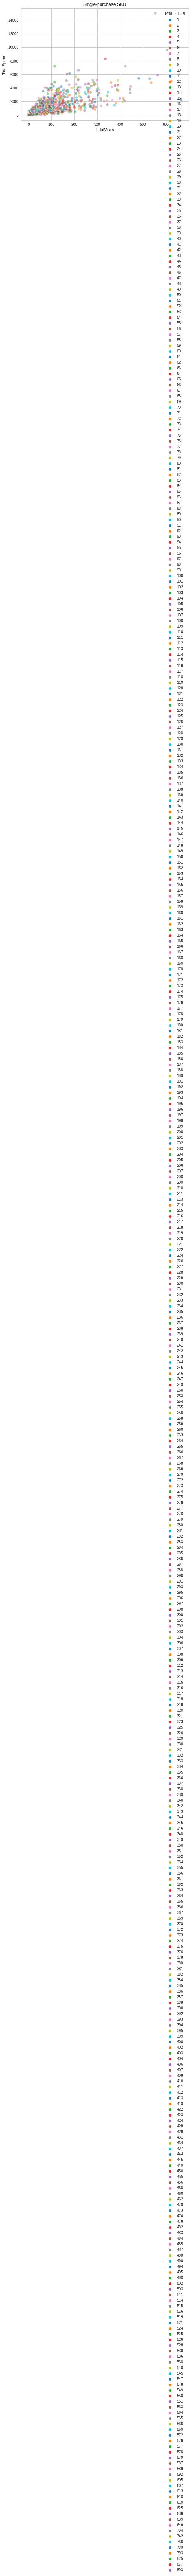

In [ ]:
palette = 'tab10'
sns.scatterplot(data=df_csv ,x='TotalVisits',y='TotalSpend',hue='TotalSKUs',alpha=.5, palette=palette)
plt.title('Single-purchase SKU')
plt.show()

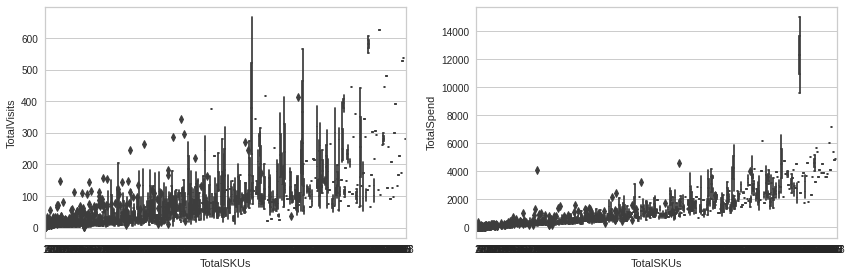

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12,4), tight_layout=True)
sns.boxplot(data=df_csv, y='TotalVisits', x='TotalSKUs', palette=palette, ax=axes[0])
sns.boxplot(data=df_csv, y='TotalSpend', x='TotalSKUs', palette=palette,ax=axes[1])
plt.show()

**Cluster customers**

In [ ]:
exp_clu = setup(data=df_csv, ignore_features=['CUST_CODE','FirstDate', 'LastDate','WkDay','WkEnd','ShopDay','ShopNight'], normalize=True)


Description                 Value
0                               session_id                  5809
1                            Original Data            (6100, 15)
2                           Missing Values                 False
3                         Numeric Features                     8
4                     Categorical Features                     0
5                         Ordinal Features                 False
6                High Cardinality Features                 False
7                  High Cardinality Method                  None
8                         Transformed Data             (6100, 8)
9                                 CPU Jobs                    -1
10                                 Use GPU                 False
11                          Log Experiment                 False
12                         Experiment Name  cluster-default-name
13                                     USI                  a123
14                         Imputation Type                simple
15          Iterative Imputation Iteration                  None
16                         Numeric Imputer                  mean
17      Iterative Imputation Numeric Model                  None
18                     Categorical Imputer                  mode
19  Iterative Imputation Categorical Model                  None
20           Unknown Categoricals Handling        least_frequent
21                               Normalize                  True
22                        Normalize Method                zscore
23                          Transformation                 False
24                   Transformation Method                  None
25                                     PCA                 False
26                              PCA Method                  None
27                          PCA Components                  None
28                     Ignore Low Variance                 False
29                     Combine Rare Levels                 False
30                    Rare Level Threshold                  None
31                         Numeric Binning                 False
32                         Remove Outliers                 False
33                      Outliers Threshold                  None
34                Remove Multicollinearity                 False
35             Multicollinearity Threshold                  None
36             Remove Perfect Collinearity                 False
37                              Clustering                 False
38                    Clustering Iteration                  None
39                     Polynomial Features                 False
40                       Polynomial Degree                  None
41                    Trignometry Features                 False
42                    Polynomial Threshold                  None
43                          Group Features                 False
44                       Feature Selection                 False
45                Feature Selection Method               classic
46            Features Selection Threshold                  None
47                     Feature Interaction                 False
48                           Feature Ratio                 False
49                   Interaction Threshold                  None

In [ ]:
models()

Name                                          Reference
ID                                                                                            
kmeans                   K-Means Clustering                     sklearn.cluster._kmeans.KMeans
ap                     Affinity Propagation  sklearn.cluster._affinity_propagation.Affinity...
meanshift             Mean Shift Clustering              sklearn.cluster._mean_shift.MeanShift
sc                      Spectral Clustering       sklearn.cluster._spectral.SpectralClustering
hclust             Agglomerative Clustering  sklearn.cluster._agglomerative.AgglomerativeCl...
dbscan     Density-Based Spatial Clustering                     sklearn.cluster._dbscan.DBSCAN
optics                    OPTICS Clustering                     sklearn.cluster._optics.OPTICS
birch                      Birch Clustering                       sklearn.cluster._birch.Birch
kmodes                   K-Modes Clustering                               kmodes.kmodes.KModes

In [ ]:
get_metrics()

Name       Display Name  ... Needs Ground Truth Custom
ID                                                 ...                          
silhouette          Silhouette         Silhouette  ...              False  False
chs          Calinski-Harabasz  Calinski-Harabasz  ...              False  False
db              Davies-Bouldin     Davies-Bouldin  ...              False  False
hs           Homogeneity Score        Homogeneity  ...               True  False
ari                 Rand Index         Rand Index  ...               True  False
cs          Completeness Score       Completeness  ...               True  False

[6 rows x 9 columns]

**Compare model performance**

In [ ]:
metrics = []
for model in models().index:
    if model in ['meanshift', 'optics']:
        continue
    create_model(model)
    metric_result = pull()
    metric_result['model'] = model
    metrics.append(metric_result)

Silhouette  Calinski-Harabasz  ...  Rand Index  Completeness
0     -0.1056           197.1317  ...           0             0

[1 rows x 6 columns]

In [ ]:
cluster_metrics = pd.concat(metrics)
cluster_metrics.set_index("model", inplace=True)
cluster_metrics.sort_values(by='Silhouette', ascending=False, inplace=True)
cluster_metrics.style.highlight_max(subset=['Silhouette', 'Calinski-Harabasz'], color = 'green', axis = 0).highlight_min(subset=['Davies-Bouldin'], color = 'green', axis = 0)

In [ ]:
sc = create_model('sc')

Silhouette  Calinski-Harabasz  ...  Rand Index  Completeness
0      0.6773            51.1818  ...           0             0

[1 rows x 6 columns]

In [ ]:
plot_model(sc)

In [ ]:
kmodes = create_model('kmodes')

Silhouette  Calinski-Harabasz  ...  Rand Index  Completeness
0     -0.1056           197.1317  ...           0             0

[1 rows x 6 columns]

In [ ]:
plot_model(kmodes)

In [ ]:
kmeans = create_model('kmeans')

Silhouette  Calinski-Harabasz  ...  Rand Index  Completeness
0      0.3231          2282.3625  ...           0             0

[1 rows x 6 columns]

In [ ]:
plot_model(kmeans)

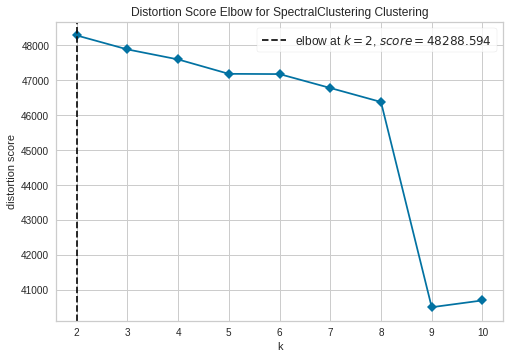

In [ ]:
plot_model(sc, plot = 'elbow')

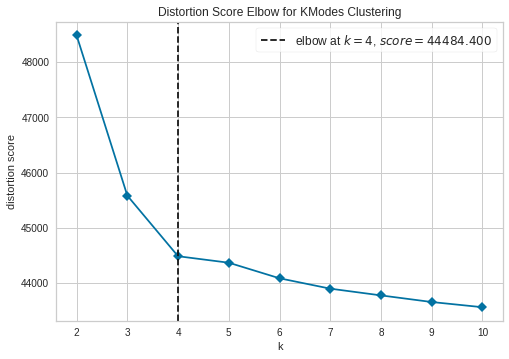

In [ ]:
plot_model(kmodes, plot = 'elbow')

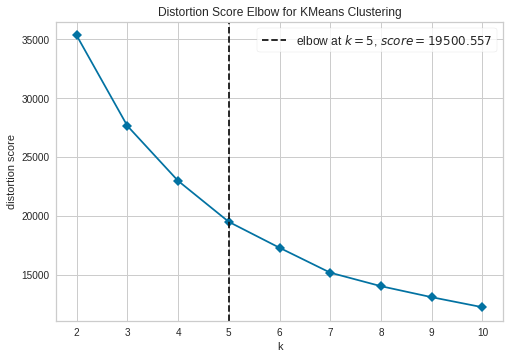

In [ ]:
plot_model(kmeans, plot = 'elbow')

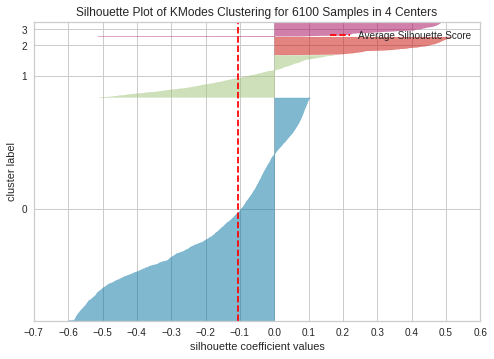

In [ ]:
plot_model(kmodes, plot = 'silhouette')

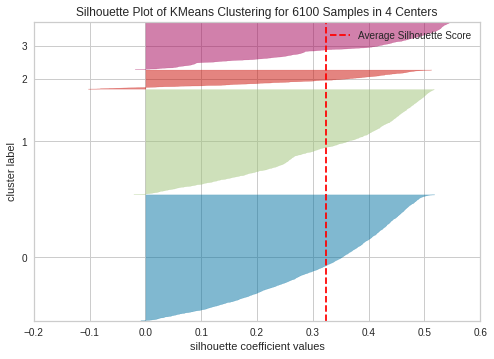

In [ ]:
plot_model(kmeans, plot = 'silhouette')

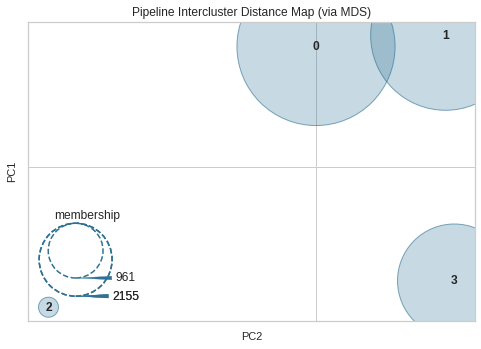

In [ ]:
plot_model(kmeans, plot = 'distance')

**KMEANS**

In [ ]:
kmeans_results = assign_model(kmeans)

In [ ]:
kmeans_results.head(5)

CUST_CODE  TotalSpend  TotalVisits  ...    WkDay%  ShopDay%    Cluster
0  CUST0000000181        2.44            1  ...  0.000000  1.000000  Cluster 3
1  CUST0000000369      959.33          220  ...  0.748212  0.931330  Cluster 2
2  CUST0000000689      328.57           16  ...  0.832432  0.443243  Cluster 0
3  CUST0000000998        5.95            3  ...  0.500000  1.000000  Cluster 3
4  CUST0000001163       39.74            4  ...  0.040000  1.000000  Cluster 0

[5 rows x 16 columns]

In [ ]:
plot_model(kmeans)

In [ ]:
# Total Distribution
plot_model(kmeans, plot = 'distribution',scale = 0.5)

In [ ]:
plot_model(kmeans, plot = 'distribution',feature = 'TotalSpend')

In [ ]:
plot_model(kmeans, plot = 'distribution',feature = 'recency')

In [ ]:
plot_model(kmeans, plot = 'distribution',feature = 'TicketSize')

In [ ]:
plot_model(kmeans, plot = 'distribution',feature = 'WkDay%')

In [ ]:
plot_model(kmeans, plot = 'distribution',feature = 'ShopDay%')

**Summary**
* The cluster 0 (Blue) : 2nd Most customers, Active user, Purchasing ast small shop mainly, Not much total spent. Try to upselling with more premium products.
* The cluster 1 (Orange) : Rich customer, not much in quantity but high value and profitable, mainly non food purchasing, very active customers. Should be the customers near the shop location. They are our treasure, bind them with the premium membership with exclusive deal, offer and make sure they we can maintan them. Considerr to brach new line with the popular "non food" product
* The cluster 2 (Green) : The most in quantity customers, low ticket size and high recency. Potential the normal customer, routinely check the price competitive of our products
* The cluster 3 (Purple) - WholeSell : Not much in this customer group, highest ticket size but Recency is quite high. Potentially deal a long-term contract selling, delivery at their place and cross-selling for another potential products.

**Logistic Regreesion**

In [ ]:
def class_convert(cl):
    if cl == 'Cluster 0':
        return 0
    if cl == 'Cluster 1':
        return 1
    if cl == 'Cluster 2':
        return 2
    if cl == 'Cluster 3':
        return 3

kmeans_results['Cluster'] = kmeans_results['Cluster'].apply(class_convert)

In [ ]:
kmeans_results.head(5)

CUST_CODE  TotalSpend  TotalVisits  ...    WkDay%  ShopDay% Cluster
0  CUST0000000181        2.44            1  ...  0.000000  1.000000       3
1  CUST0000000369      959.33          220  ...  0.748212  0.931330       2
2  CUST0000000689      328.57           16  ...  0.832432  0.443243       0
3  CUST0000000998        5.95            3  ...  0.500000  1.000000       3
4  CUST0000001163       39.74            4  ...  0.040000  1.000000       0

[5 rows x 16 columns]

In [ ]:
from pycaret.classification import *

In [ ]:
clf1 = setup(kmeans_results, target = 'Cluster', session_id=123, log_experiment=True, experiment_name='recency')

Description            Value
0                               session_id              123
1                                   Target          Cluster
2                              Target Type       Multiclass
3                            Label Encoded             None
4                            Original Data       (6100, 16)
5                           Missing Values            False
6                         Numeric Features               12
7                     Categorical Features                1
8                         Ordinal Features            False
9                High Cardinality Features            False
10                 High Cardinality Method             None
11                   Transformed Train Set     (4269, 4323)
12                    Transformed Test Set     (1831, 4323)
13                      Shuffle Train-Test             True
14                     Stratify Train-Test            False
15                          Fold Generator  StratifiedKFold
16                             Fold Number               10
17                                CPU Jobs               -1
18                                 Use GPU            False
19                          Log Experiment             True
20                         Experiment Name          recency
21                                     USI             2b89
22                         Imputation Type           simple
23          Iterative Imputation Iteration             None
24                         Numeric Imputer             mean
25      Iterative Imputation Numeric Model             None
26                     Categorical Imputer         constant
27  Iterative Imputation Categorical Model             None
28           Unknown Categoricals Handling   least_frequent
29                               Normalize            False
30                        Normalize Method             None
31                          Transformation            False
32                   Transformation Method             None
33                                     PCA            False
34                              PCA Method             None
35                          PCA Components             None
36                     Ignore Low Variance            False
37                     Combine Rare Levels            False
38                    Rare Level Threshold             None
39                         Numeric Binning            False
40                         Remove Outliers            False
41                      Outliers Threshold             None
42                Remove Multicollinearity            False
43             Multicollinearity Threshold             None
44             Remove Perfect Collinearity             True
45                              Clustering            False
46                    Clustering Iteration             None
47                     Polynomial Features            False
48                       Polynomial Degree             None
49                    Trignometry Features            False
50                    Polynomial Threshold             None
51                          Group Features            False
52                       Feature Selection            False
53                Feature Selection Method          classic
54            Features Selection Threshold             None
55                     Feature Interaction            False
56                           Feature Ratio            False
57                   Interaction Threshold             None
58                           Fix Imbalance            False
59                    Fix Imbalance Method            SMOTE

In [ ]:
lr = create_model('lr')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.9789  0.9978  0.9710  0.9800  0.9791  0.9684  0.9686
1       0.9742  0.9994  0.9764  0.9745  0.9742  0.9614  0.9615
2       0.9789  0.9978  0.9776  0.9791  0.9789  0.9683  0.9683
3       0.9766  0.9991  0.9591  0.9769  0.9765  0.9647  0.9649
4       0.9859  0.9997  0.9758  0.9860  0.9859  0.9789  0.9790
5       0.9719  0.9989  0.9602  0.9722  0.9719  0.9577  0.9578
6       0.9742  0.9965  0.9400  0.9740  0.9738  0.9611  0.9613
7       0.9742  0.9983  0.9738  0.9751  0.9745  0.9615  0.9615
8       0.9766  0.9981  0.9635  0.9765  0.9765  0.9648  0.9648
9       0.9624  0.9948  0.9645  0.9631  0.9625  0.9438  0.9440
Mean    0.9754  0.9980  0.9662  0.9758  0.9754  0.9630  0.9632
SD      0.0057  0.0014  0.0109  0.0056  0.0057  0.0085  0.0085

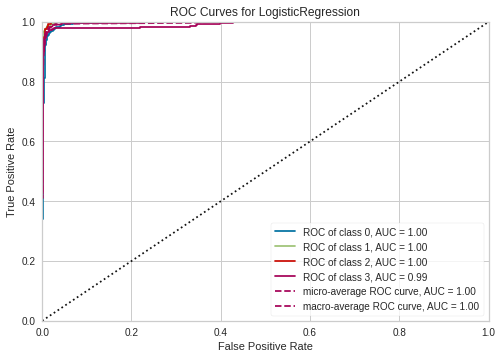

In [50]:
plot_model(lr)

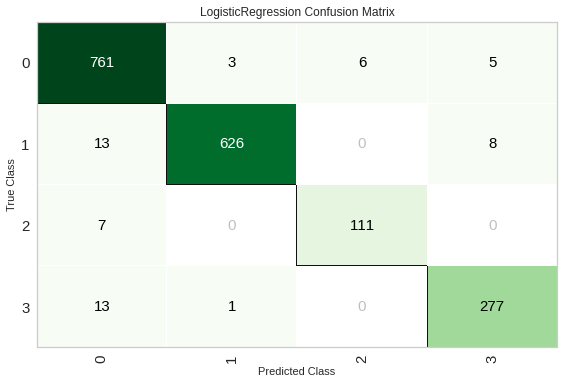

In [52]:
plot_model(lr, plot = 'confusion_matrix')

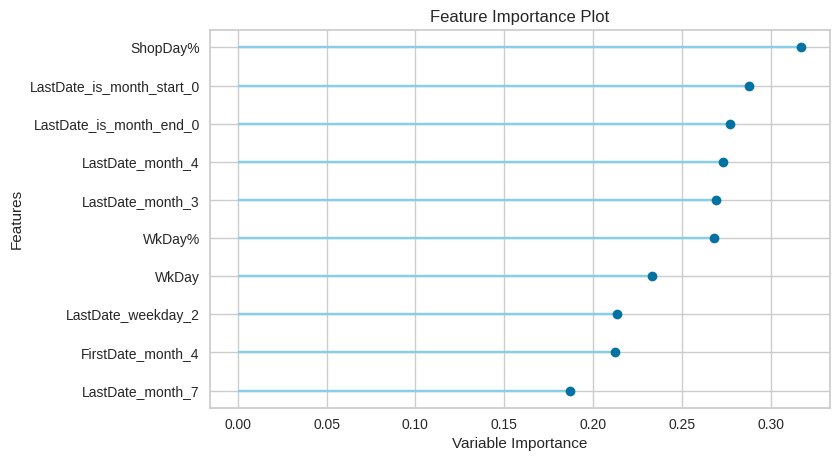

In [53]:
plot_model(lr, plot = 'feature')

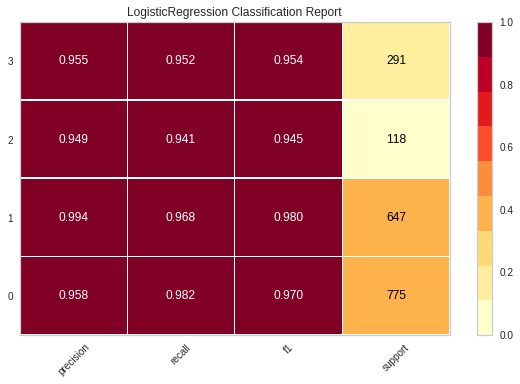

In [54]:
plot_model(lr, plot = 'class_report')

In [55]:
evaluate_model(lr)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [57]:
pred_holdouts = predict_model(lr)
pred_holdouts.head(10)

Model  Accuracy     AUC  Recall   Prec.      F1  Kappa     MCC
0  Logistic Regression    0.9694  0.9966  0.9605  0.9697  0.9695  0.954  0.9542

TotalSpend  TotalVisits  TotalSKUs  ...  Cluster  Label   Score
0  3624.989990        125.0      576.0  ...        2      2  1.0000
1    21.299999          7.0       14.0  ...        0      0  1.0000
2    33.380001          8.0       13.0  ...        0      0  0.9731
3     2.480000          1.0        2.0  ...        3      3  0.9932
4   571.650024         23.0      143.0  ...        0      0  1.0000
5     7.990000          1.0        5.0  ...        1      1  0.9999
6    16.969999         13.0        8.0  ...        0      0  1.0000
7   101.930000          5.0       51.0  ...        0      0  1.0000
8     1.820000          1.0        2.0  ...        1      1  0.9949
9   269.970001         24.0      103.0  ...        0      0  1.0000

[10 rows x 4326 columns]